# MIDS W261: Machine Learning at Scale

Konniam Chan  
Time of submission: 12:30am PST   
W261-3 Spring 2016    
Week 2: Homework  
January 26, 2016  

### HW2.0.  
What is a race condition in the context of parallel computation? Give an example.
What is MapReduce?
How does it differ from Hadoop?
Which programming paradigm is Hadoop based on? Explain and give a simple example in code and show the code running.

- Race condition could manifest itself as a bug in a parallel program without synchronization. The final value of the operation depends on operation order. For instance, if both A and B were to perform an operation X = X + 1, on the same variable. Depending on which gets done first, the result could be X + 1 or X + 2.
- MapReduce is a parallel programming paradigm that enables distributed processing of data sets on commodity nodes. Hadoop is a set of open-source projects that facilitate parallel computing, including MapReduce, HDFS, Avro, Hive, and other utilities.
- Hadoop utilizes MapReduce for processing, which resembles functional programming closely. Functional programming treats computations as functions, and avoids saving states whenever possible. MapReduce closely approximates the map and reduce functions in that regime. Examine sample code below:

In [409]:
# Mapper
input = [1,2,3,4,5]
# Compute x^2 using map
print "Sample mapper that computes x-square:"
print map(lambda x: x**2, input)

# Reducer
print "Sample reducer sums all elements:"
print reduce(lambda x,y: x+y, input)

# Note: both mapper and reducer take another function, and use that function to transform the input

Sample mapper that computes x-square:
[1, 4, 9, 16, 25]
Sample reducer sums all elements:
15


### HW2.1. Sort in Hadoop MapReduce
Given as input: Records of the form `<integer, “NA”>`, where integer is any integer, and “NA” is just the empty string.
Output: sorted key value pairs of the form `<integer, “NA”>` in decreasing order; what happens if you have multiple reducers? Do you need additional steps? Explain.

Write code to generate N  random records of the form `<integer, “NA”>`. Let N = 10,000.
Write the python Hadoop streaming map-reduce job to perform this sort. Display the top 10 biggest numbers. Display the 10 smallest numbers

In [1]:
## Start HDFS and Yarn
!start-yarn.sh
!start-dfs.sh

starting yarn daemons
starting resourcemanager, logging to /Users/InfernoIX/hadoop-2.7.1/logs/yarn-InfernoIX-resourcemanager-Konniams-MacBook-Air.local.out
localhost: starting nodemanager, logging to /Users/InfernoIX/hadoop-2.7.1/logs/yarn-InfernoIX-nodemanager-Konniams-MacBook-Air.local.out
16/01/23 15:26:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Starting namenodes on [localhost]
localhost: starting namenode, logging to /Users/InfernoIX/hadoop-2.7.1/logs/hadoop-InfernoIX-namenode-Konniams-MacBook-Air.local.out
localhost: starting datanode, logging to /Users/InfernoIX/hadoop-2.7.1/logs/hadoop-InfernoIX-datanode-Konniams-MacBook-Air.local.out
Starting secondary namenodes [0.0.0.0]
0.0.0.0: starting secondarynamenode, logging to /Users/InfernoIX/hadoop-2.7.1/logs/hadoop-InfernoIX-secondarynamenode-Konniams-MacBook-Air.local.out
16/01/23 15:26:37 WARN util.NativeCodeLoader: Unable to load native-had

In [1]:
# Import packages
from __future__ import division
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [410]:
# Create input file
def hw_2_1():
    np.random.seed(0)
    # Pick 10,000 numbers from 100,000 and save to txt
    N = 10000
    # Save
    np.savetxt("hw_2_1.txt", np.random.randint(0, 100000, N), fmt='%i,')

hw_2_1()

In [41]:
!wc -l hw_2_1.txt

   10000 hw_2_1.txt


In [411]:
!head hw_2_1.txt

68268,
43567,
42613,
45891,
21243,
95939,
97639,
41993,
86293,
55026,


In [24]:
# Put on HDFS
!hdfs dfs -put hw_2_1.txt /user/konniam/week_02

16/01/23 01:10:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [412]:
%%writefile ~/mapper.py
#!/usr/bin/env python
# MapReduce Task to Sort Numbers
# The mapper will split the record of the form <integer, ""> into <integer \t>.
# This output will get sorted in reverse numerical order.
# The reducer doesn't need to do anything, so it could be an IdentityReducer
import sys
for line in sys.stdin:
    # Extract the number
    num = line.strip().split(',')[0]
    # Output the number
    print num

Overwriting /Users/InfernoIX/mapper.py


In [70]:
!chmod a+x ~/mapper.py

In [420]:
# Run MapReduce job
# The keycomparator options make the sorting come in descending order
# Use 1 reducer
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator \
-D mapreduce.partition.keycomparator.options=-k1,1nr \
-D mapreduce.job.reduces=1 \
-mapper ~/mapper.py \
-reducer org.apache.hadoop.mapred.lib.IdentityReducer \
-input /user/konniam/week_02/hw_2_1.txt \
-output /user/konniam/week_02/hw_2_1_output \

16/01/25 23:28:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar8474472715611845283/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob679131600247708839.jar tmpDir=null
16/01/25 23:28:51 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/25 23:28:51 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/25 23:28:52 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/25 23:28:53 INFO mapreduce.JobSubmitter: number of splits:2
16/01/25 23:28:53 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453765434085_0010
16/01/25 23:28:53 INFO impl.YarnClientImpl: Submitted application application_1453765434085_0010
16/01/25 23:28:53 INFO mapreduce.Job: The url to track the job: http://Konniams-MacBook-Air.local:8088/proxy/application_1453765434085_0010/
16/0

In [421]:
# Display 10 biggest numbers
!hdfs dfs -cat /user/konniam/week_02/hw_2_1_output/* | head

16/01/25 23:29:33 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
99980	
99975	
99965	
99963	
99943	
99938	
99920	
99914	
99913	
99892	
cat: Unable to write to output stream.


In [422]:
# Display 10 smallest numbers
!hdfs dfs -cat /user/konniam/week_02/hw_2_1_output/* | tail

16/01/25 23:29:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
102	
100	
95	
93	
75	
43	
30	
21	
13	
10	


#### 2.1 Response
Here we used one reducer. If we were to use multiple reducers, each reducer will output its own file with sorted numbers. However, unless we sort all the numbers before we partition them for the reducers. We only get a few files with their own sorted list. We would have to sort all the files one more time.

### HW2.2.  WORDCOUNT
Using the Enron data from HW1 and Hadoop MapReduce streaming, write the mapper/reducer job that  will determine the word count (number of occurrences) of each white-space delimitted token (assume spaces, fullstops, comma as delimiters). Examine the word “assistance” and report its word count results.

 
CROSSCHECK: >grep assistance enronemail_1h.txt|cut -d$'\t' -f4| grep assistance|wc -l    
       8    
NOTE  "assistance" occurs on 8 lines but how many times does the token occur? 10 times! This is the number we are looking for!

(Optional)
Remove ^A and ^M characters using vi from the training data first.

In [55]:
%%writefile ~/mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Konniam Chan
## Description: mapper code for HW2.2
import sys
import re
import string
from collections import Counter

# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')
# Counter dictionary
wordcounts = Counter()

# Process each document
for line in sys.stdin:
    # Lower case
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "na"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body    
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    # Sum words that go through each mapper
    wordcounts += Counter(words)

# Output
for word, count in wordcounts.items():
    print '%s\t%s' % (word, count)

Overwriting /Users/InfernoIX/mapper.py


In [59]:
%%writefile ~/reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Konniam Chan
## Description: reducer code for HW2.2
import sys
current_word = None
current_count = 0
word = None

for line in sys.stdin:
    # Obtain word and intermediate counts
    line = line.strip()
    word, count = line.split('\t', 1)
    count = int(count)
    # Rely on sorting to increment word counts
    if current_word == word:
        current_count += count
    else:
        if current_word:            
            print '%s\t%s' % (current_word, current_count)
        current_count = count
        current_word = word

# Output last word
if current_word == word:
    print '%s\t%s' % (current_word, current_count)

Overwriting /Users/InfernoIX/reducer.py


In [11]:
!chmod a+x ~/reducer.py

In [63]:
# Put enron emails onto HDFS
!hdfs dfs -put enronemail_1h.txt /user/konniam/week_02

16/01/24 11:57:21 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [65]:
# Run MapReduce job
# Specify 1 reducer in this case 
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=1 \
-mapper ~/mapper.py \
-reducer ~/reducer.py \
-input /user/konniam/week_02/enronemail_1h.txt \
-output /user/konniam/week_02/hw_2_2_output \

16/01/24 11:58:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar2874213692464979909/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob1868682628016300695.jar tmpDir=null
16/01/24 11:58:06 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 11:58:06 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 11:58:07 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 11:58:07 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 11:58:07 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453657675452_0002
16/01/24 11:58:07 INFO impl.YarnClientImpl: Submitted application application_1453657675452_0002
16/01/24 11:58:07 INFO mapreduce.Job: The url to track the job: http://Konniams-MacBook-Air.local:8088/proxy/application_1453657675452_0002/
16/

In [67]:
# Check the word "assistance"
!hdfs dfs -cat /user/konniam/week_02/hw_2_2_output/* | grep assistance

16/01/24 12:01:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
assistance	10


### HW2.2.1  
Using Hadoop MapReduce and your wordcount job (from HW2.2) determine the top-10 occurring tokens (most frequent tokens)

In [66]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_2_output/* | sort -k2,2nr | head

16/01/24 12:00:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
the	1240
to	914
and	659
of	556
a	527
in	415
you	407
your	389
for	369
@	361
sort: write failed: standard output: Broken pipe
sort: write error


### HW2.3. Multinomial NAIVE BAYES with NO Smoothing
Using the Enron data from HW1 and Hadoop MapReduce, write  a mapper/reducer job(s) that
   will both learn  Naive Bayes classifier and classify the Enron email messages using the learnt Naive Bayes classifier. Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Note: for multinomial Naive Bayes, the Pr(X=“assistance”|Y=SPAM) is calculated as follows:

   the number of times “assistance” occurs in SPAM labeled documents / the number of words in documents labeled SPAM 

   E.g.,   “assistance” occurs 5 times in all of the documents Labeled SPAM, and the length in terms of the number of words in all documents labeled as SPAM (when concatenated) is 1,000. Then Pr(X=“assistance”|Y=SPAM) = 5/1000. Note this is a multinomial estimation of the class conditional for a Naive Bayes Classifier. No smoothing is needed in this HW. Multiplying lots of probabilities, which are between 0 and 1, can result in floating-point underflow. Since log(xy) = log(x) + log(y), it is better to perform all computations by summing logs of probabilities rather than multiplying probabilities. Please pay attention to probabilites that are zero! They will need special attention. Count up how many times you need to process a zero probabilty for each class and report. 

   Report the performance of your learnt classifier in terms of misclassifcation error rate of your multinomial Naive Bayes Classifier. Plot a histogram of the log posterior probabilities (i.e., log(Pr(Class|Doc))) for each class over the training set. Summarize what you see. 

   Error Rate = misclassification rate with respect to a provided set (say training set in this case). It is more formally defined here:

Let DF represent the evalution set in the following:
Err(Model, DF) = |{(X, c(X)) ∈ DF : c(X) != Model(x)}|   / |DF|

Where || denotes set cardinality; c(X) denotes the class of the tuple X in DF; and Model(X) denotes the class inferred by the Model “Model”

#### 2.3 Strategy
Split this exercise into 2 sets of MR jobs.  
**Training Step**  
1 - Mapper: (Input docs) -> intermediate (word, spam/ham, count)  
1 - Reducer: intermediate (word, spam/ham, count) -> final (word, spam/ham, count)  
**Classification Step**  
2 - Mapper: (Input docs) -> predicted labels  
2 - Reducer: None  
(pass in word counts from training step to do classification)  
  
We will use this same strategy for all MapReduce NB jobs here in this HW.

#### 2.3 Training

In [259]:
%%writefile ~/mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Konniam Chan
## Description: mapper code for HW2.3
import sys
import re
import string
from collections import Counter
# Map from integer label to word label
label_map = {"1":"spam", "0":"ham"}
# Dictionary to keep track of terms
wordcounts = {"spam": Counter(), "ham": Counter()}
# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')

# Process each document
for line in sys.stdin:
    # Lower case
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "na"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    # Sum words that go through each mapper
    label = label_map[label]
    wordcounts[label] += Counter(words)
    # Increment number of documents
    wordcounts[label]["*numdocs"] += 1
# Output each word
for label in wordcounts:
    for word in wordcounts[label]:
        print '%s\t%s\t%s' % (word, label, wordcounts[label][word])

Overwriting /Users/InfernoIX/mapper.py


In [260]:
%%writefile ~/reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Konniam Chan
## Description: reducer code for HW2.3
import sys
from collections import Counter

# Dictionary to keep track of terms
wordcounts = {"spam": Counter(), "ham": Counter()}
# Process each tuple in the form of (word, spam/ham, count) separated by \t
for line in sys.stdin:
    word, label, count = line.strip().split("\t")
    wordcounts[label][word] += int(count)

# Output each word
for label in wordcounts:
    for word in wordcounts[label]:
        print '%s\t%s\t%s' % (word, label, wordcounts[label][word])

Overwriting /Users/InfernoIX/reducer.py


In [75]:
# Run MapReduce job
# Specify 1 reducer
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=1 \
-mapper ~/mapper.py \
-reducer ~/reducer.py \
-input /user/konniam/week_02/enronemail_1h.txt \
-output /user/konniam/week_02/hw_2_3_output

16/01/24 12:07:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar8048476221407268102/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob3395343983938593158.jar tmpDir=null
16/01/24 12:07:03 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 12:07:04 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 12:07:05 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 12:07:05 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 12:07:05 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453657675452_0004
16/01/24 12:07:05 INFO impl.YarnClientImpl: Submitted application application_1453657675452_0004
16/01/24 12:07:05 INFO mapreduce.Job: The url to track the job: http://Konniams-MacBook-Air.local:8088/proxy/application_1453657675452_0004/
16/

In [152]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_3_output/part* | sort -k1,1 | head

16/01/24 15:43:47 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
!!	spam	1
""	ham	83
""	spam	174
""'bcli	ham	1
""'benewm	ham	1
""'bjeffrie	ham	1
""'blong	ham	1
""'bredd	ham	1
""'celias	ham	1
""'cenochs	ham	1
sort: write failed: standard output: Broken pipe
sort: write error


#### 2.3 Classification
The above MR job trained the model by obtaining the counts of all terms in either spam or ham.  
We can now pass the result file from above when we want to classify our training data.

In [121]:
%%writefile ~/mapper_classify.py
#!/usr/bin/env python
## mapper_classify.py
## Author: Konniam Chan
## Description: classification mapper code for HW2.3
from __future__ import division
import sys
import re
import string
import math

# Map from integer label to word label
label_map = {"1":"spam", "0":"ham"}
# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')

# Load trained Naive Bayes model in memory
wordcounts = {"spam": {}, "ham": {}}
with open("wordcounts_2_3.txt", "r") as f:
    for line in f:
        word, label, count = line.strip().split("\t")
        wordcounts[label][word] = int(count)
# Calculate total number of terms
terms_spam = sum(wordcounts['spam'].values())
terms_ham = sum(wordcounts['ham'].values())
# Calculate priors
prior_spam = wordcounts['spam']['*numdocs'] / (wordcounts['spam']['*numdocs'] + wordcounts['ham']['*numdocs'])
prior_ham = 1 - prior_spam

# Process each document
for line in sys.stdin:
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "na"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    
    # Initialize probabilities with priors
    log_probs = {"spam": math.log(prior_spam), "ham": math.log(prior_ham)}
    # Keep track of number of zero probabilities for each doc
    zero_spam, zero_ham = 0, 0
    # Iterate through each word and add probabilities
    for word in words:
        # If word frequency is zero, record it, then skip the term
        if word not in wordcounts['spam'] or word not in wordcounts['ham']:
            if word not in wordcounts['spam']:
                zero_spam += 1
            else:
                zero_ham += 1
            # Skip this term in calculation of probabilities
            continue
        else:
            # Usual definition of NB probabilities
            log_probs["spam"] += math.log(wordcounts['spam'][word] / terms_spam)
            log_probs["ham"] += math.log(wordcounts['ham'][word] / terms_ham)

    # Classify
    predicted_label = "1" if log_probs["spam"] > log_probs["ham"] else "0"
    # Normalize probabilities for output, prevent overflow
    if log_probs["ham"] - log_probs["spam"] > 700:
            probs_spam = 0
    else:
        probs_spam = 1 / (1 + math.exp(log_probs["ham"] - log_probs["spam"]))
    probs_ham = 1 - probs_spam
    
    # Output (DocID, label, predicted label, p_spam, p_ham, zero_spam, zero_ham)
    print '\t'.join([doc_id, label, predicted_label, 
                     str(probs_spam), str(probs_ham),
                     str(zero_spam), str(zero_ham)])

Overwriting /Users/InfernoIX/mapper_classify.py


In [134]:
!chmod a+x ~/mapper_classify.py

In [96]:
# Transfer results from 1st MR job to a local directory
!hdfs dfs -get "/user/konniam/week_02/hw_2_3_output/part-00000" ~/wordcounts_2_3.txt

16/01/24 13:53:07 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/01/24 13:53:08 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [122]:
# Run MapReduce job
# Map-only job. Pass in text file with wordcounts
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=0 \
-mapper ~/mapper_classify.py \
-input /user/konniam/week_02/enronemail_1h.txt \
-output /user/konniam/week_02/hw_2_3_output_classify \
-file ~/wordcounts_2_3.txt

16/01/24 15:04:59 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/01/24 15:04:59 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/Users/InfernoIX/wordcounts_2_3.txt, /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar4598644515510618160/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob3052404937059671916.jar tmpDir=null
16/01/24 15:05:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 15:05:01 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 15:05:02 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 15:05:03 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 15:05:03 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453657675452_0008
16/01/24 15:05:03 INFO impl.YarnClientImpl: Submitted application application_145365767545

In [136]:
# Examine output (format: DocID, label, predicted_label, zero_spam, zero_ham)
!hdfs dfs -cat /user/konniam/week_02/hw_2_3_output_classify/part* | head

16/01/24 15:14:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
0011.2003-12-18.gp	1	1	0.999999989025	1.09750638577e-08	0	37
0011.2004-08-01.bg	1	1	0.999999956896	4.3104383729e-08	0	37
0012.1999-12-14.farmer	0	0	1.51562851903e-45	1.0	142	0
0012.1999-12-14.kaminski	0	0	3.07583767617e-35	1.0	62	0
0012.2000-01-17.beck	0	0	4.96321540941e-110	1.0	156	0
0012.2000-06-08.lokay	0	1	0.999999997354	2.64601918154e-09	31	0
0012.2001-02-09.kitchen	0	0	7.99826839655e-06	0.999992001732	20	0
0012.2003-12-19.gp	1	1	0.996915425172	0.00308457482785	0	9
0013.1999-12-14.farmer	0	0	3.9936291718e-25	1.0	69	0
0013.1999-12-14.kaminski	0	0	3.51968974018e-38	1.0	67	0
cat: Unable to write to output stream.


#### 2.3 Error Assessment

In [132]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_3_output_classify/part* > hw_2_3_results.txt

16/01/24 15:12:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Number of words that hit zero probability for class spam: 4932.
Number of words that hit zero probability for class ham: 6447.
The training error is 0.11.


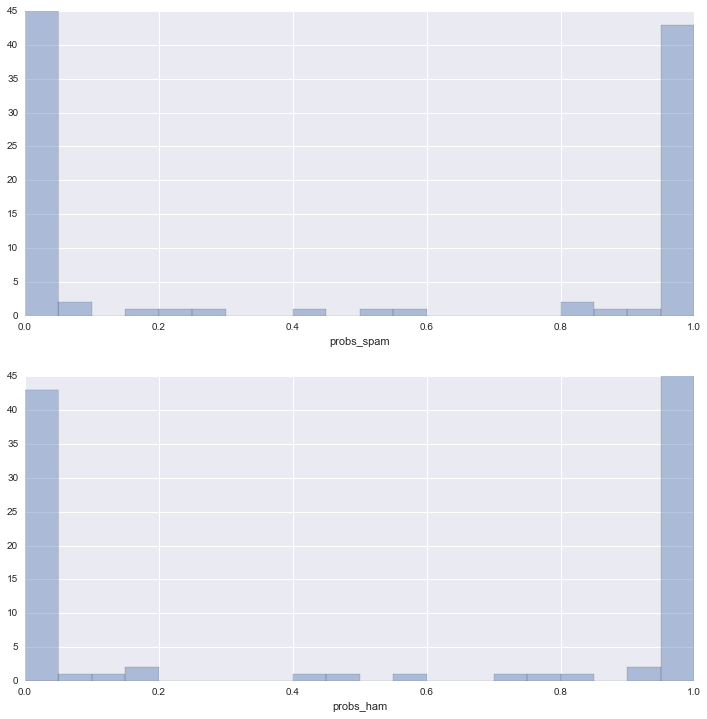

In [170]:
def hw_2_3_error():
    # Parse results
    columns = ['docid', 'label', 'preds', 'probs_spam', 'probs_ham', 'zero_spam', 'zero_ham']
    df = pd.read_table("hw_2_3_results.txt", header=None, names=columns)
    # Print total number of zero probabilities for each class
    print "Number of words that hit zero probability for class spam: {}.".format(
        sum(df['zero_spam']))
    print "Number of words that hit zero probability for class ham: {}.".format(
        sum(df['zero_ham']))
    # Calculate error rate and output
    print "The training error is {}.".format(np.mean(df['label'] != df['preds']))
    # Plot histograms
    plt.figure(figsize=(12,12))
    plt.subplot(211)
    sns.distplot(df['probs_spam'], bins = 20, kde=None)
    plt.subplot(212)
    sns.distplot(df['probs_ham'], bins = 20, kde=None)

hw_2_3_error()

#### 2.3 Response

The error (without smoothing) is 11%, which is pretty bad considering we have over 7000 parameters for 100 data points. 4932 and 6447 terms hit zero probabilities for either spam or ham, and are skipped in the NB calculation both both classes.  
  
The plots of the probabilities show a very bimodal distribution, with significant density near 0 or 1, showing that NB is usually very confident in its predictions.

### HW2.4 
Repeat HW2.3 with the following modification: use Laplace plus-one smoothing. Compare the misclassifcation error rates for 2.3 versus 2.4 and explain the differences.

For a quick reference on the construction of the Multinomial NAIVE BAYES classifier that you will code,
please consult the "Document Classification" section of the following wikipedia page:

https://en.wikipedia.org/wiki/Naive_Bayes_classifier#Document_classification

OR the original paper by the curators of the Enron email data:

http://www.aueb.gr/users/ion/docs/ceas2006_paper.pdf

#### 2.4 Strategy
The classifier with Laplace smoothing can use the wordcounts created in the 1st MR job from 2.3. All we have to do is to modify how we calculate how probabilities.

#### 2.4 Classification

In [174]:
%%writefile ~/mapper_classify.py
#!/usr/bin/env python
## mapper_classify.py
## Author: Konniam Chan
## Description: classification (with Laplace smoothing) mapper code for HW2.4
from __future__ import division
import sys
import re
import string
import math
from collections import defaultdict

# Map from integer label to word label
label_map = {"1":"spam", "0":"ham"}
# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')

# Load wordcounts from 2.3 in memory
wordcounts = {"spam": defaultdict(int), "ham": defaultdict(int)}
with open("wordcounts_2_3.txt", "r") as f:
    for line in f:
        word, label, count = line.strip().split("\t")
        wordcounts[label][word] = int(count)
# Calculate total number of terms
terms_spam = sum(wordcounts['spam'].values())
terms_ham = sum(wordcounts['ham'].values())
# Calculate priors and size of vocab
prior_spam = wordcounts['spam']['*numdocs'] / (wordcounts['spam']['*numdocs'] + wordcounts['ham']['*numdocs'])
prior_ham = 1 - prior_spam
vocab_size = len(set(wordcounts['spam']).union(set(wordcounts['ham'])))

# Process each document
for line in sys.stdin:
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "na"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    
    # Initialize probabilities with priors
    log_probs = {"spam": math.log(prior_spam), "ham": math.log(prior_ham)}
    # Iterate through each word and add probabilities
    for word in words:
        # Laplace smoothing
        log_probs["spam"] += math.log((wordcounts['spam'][word] + 1) / 
                                      (terms_spam + vocab_size))
        log_probs["ham"] += math.log((wordcounts['ham'][word] + 1) / 
                                     (terms_ham + vocab_size))

    # Classify
    predicted_label = "1" if log_probs["spam"] > log_probs["ham"] else "0"
    # Normalize probabilities for output, prevent overflow
    if log_probs["ham"] - log_probs["spam"] > 700:
            probs_spam = 0
    else:
        probs_spam = 1 / (1 + math.exp(log_probs["ham"] - log_probs["spam"]))
    probs_ham = 1 - probs_spam
    
    # Output (DocID, label, predicted label, p_spam, p_ham)
    print '\t'.join([doc_id, label, predicted_label, 
                     str(probs_spam), str(probs_ham)])

Overwriting /Users/InfernoIX/mapper_classify.py


In [176]:
# Run MapReduce job
# Map-only job. Pass in text file with wordcounts
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=0 \
-mapper ~/mapper_classify.py \
-input /user/konniam/week_02/enronemail_1h.txt \
-output /user/konniam/week_02/hw_2_4_output_classify \
-file ~/wordcounts_2_3.txt

16/01/24 16:42:15 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/01/24 16:42:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/Users/InfernoIX/wordcounts_2_3.txt, /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar5566856366020640196/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob3587086667827603933.jar tmpDir=null
16/01/24 16:42:17 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 16:42:17 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 16:42:18 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 16:42:18 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 16:42:18 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453657675452_0010
16/01/24 16:42:19 INFO impl.YarnClientImpl: Submitted application application_145365767545

In [177]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_4_output_classify/part* | head

16/01/24 16:42:44 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
0011.2003-12-18.gp	1	1	1.0	0.0
0011.2004-08-01.bg	1	1	1.0	0.0
0012.1999-12-14.farmer	0	0	3.04906108027e-156	1.0
0012.1999-12-14.kaminski	0	0	2.5675875679e-107	1.0
0012.2000-01-17.beck	0	0	8.15760689166e-266	1.0
0012.2000-06-08.lokay	0	0	4.71892179913e-09	0.999999995281
0012.2001-02-09.kitchen	0	0	2.59286926427e-14	1.0
0012.2003-12-19.gp	1	1	0.99999901192	9.88080343989e-07
0013.1999-12-14.farmer	0	0	1.94778405505e-69	1.0
0013.1999-12-14.kaminski	0	0	3.59263723869e-120	1.0
cat: Unable to write to output stream.


In [178]:
# Copy file back to local directory
!hdfs dfs -cat /user/konniam/week_02/hw_2_4_output_classify/part* > hw_2_4_results.txt

16/01/24 16:42:53 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2.4 Error Assessment

The training error is 0.0.


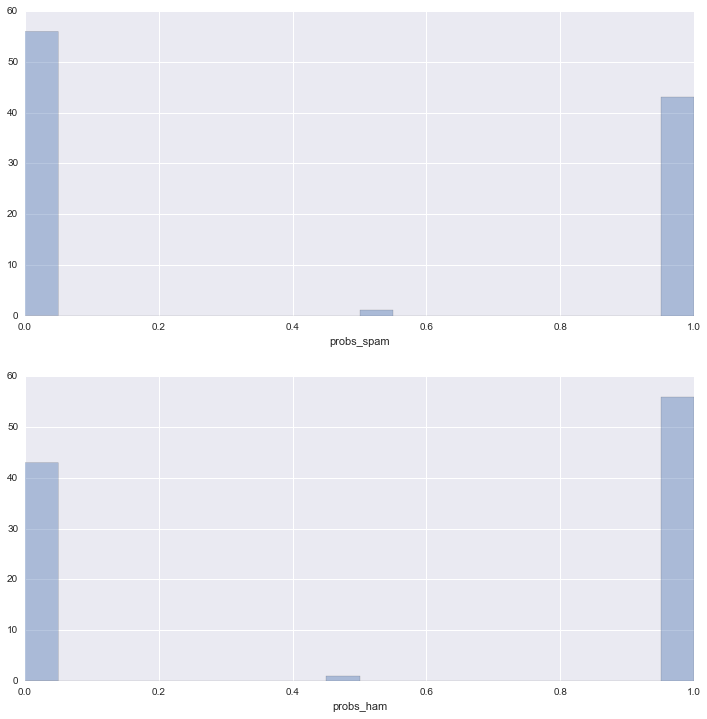

In [179]:
def hw_2_4_error():
    # Parse results
    columns = ['docid', 'label', 'preds', 'probs_spam', 'probs_ham']
    df = pd.read_table("hw_2_4_results.txt", header=None, names=columns)    
    # Calculate error rate and output
    print "The training error is {}.".format(np.mean(df['label'] != df['preds']))
    # Plot histograms
    plt.figure(figsize=(12,12))
    plt.subplot(211)
    sns.distplot(df['probs_spam'], bins = 20, kde=None)
    plt.subplot(212)
    sns.distplot(df['probs_ham'], bins = 20, kde=None)

hw_2_4_error()

#### 2.4 Response

With Laplace smoothing, the model produced a training error of 0%, a drop from the previous erorr of 11%. In the case without smoothing, we skipped over many terms that don't have conditional probabilities in one class. However, such terms are valuable precisely because of this. For instance, "lottery" might have appeared 20 times in spam but not ham. Thus, "lottery" is a great predictor of the class. Laplace smoothing allows such terms to be included and we expected the in-sample error rate to improve.  
  
Nonetheless, we should not get too excited about 0% error because we have over 7000 parameters and only 100 examples. There likely is a substantial amount of overfitting and we don't expect the out-of-sample performance to be great.

### HW2.5.
Repeat HW2.4. This time when modeling and classification ignore tokens with a frequency of less than three (3) in the training set. How does it affect the misclassifcation error of learnt naive multinomial Bayesian Classifier on the training dataset:

#### 2.5 Strategy
Like HW2.4, we can use the wordcount data from the 1st MR job from 2.3. We first change the vocab dictionary in our classifier mapper. Then we'll have to skip these terms in the prediction step.

In [201]:
%%writefile ~/mapper_classify.py
#!/usr/bin/env python
## mapper_classify.py
## Author: Konniam Chan
## Description: classification (with Laplace smoothing, ignore infrequent terms) 
## mapper code for HW2.5
from __future__ import division
import sys
import re
import string
import math
from collections import defaultdict

# Map from integer label to word label
label_map = {"1":"spam", "0":"ham"}
# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')

# Load wordcounts from 2.3 in memory
wordcounts = {"spam": defaultdict(int), "ham": defaultdict(int)}
with open("wordcounts_2_3.txt", "r") as f:
    for line in f:
        word, label, count = line.strip().split("\t")
        wordcounts[label][word] = int(count)
# Drop terms with total frequencies less than 3
vocab_set = set(wordcounts['spam']).union(set(wordcounts['ham']))
for word in vocab_set:
    if (wordcounts['spam'][word] + wordcounts['ham'][word]) < 3:
        del wordcounts['spam'][word]
        del wordcounts['ham'][word]
# Update vocabulary after deletion    
vocab_set = set(wordcounts['spam']).union(set(wordcounts['ham']))        
vocab_size = len(vocab_set)

# Calculate total number of terms
terms_spam = sum(wordcounts['spam'].values())
terms_ham = sum(wordcounts['ham'].values())
# Calculate priors and size of vocab
prior_spam = wordcounts['spam']['*numdocs'] / (wordcounts['spam']['*numdocs'] + wordcounts['ham']['*numdocs'])
prior_ham = 1 - prior_spam


# Process each document
for line in sys.stdin:
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "na"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    
    # Initialize probabilities with priors
    log_probs = {"spam": math.log(prior_spam), "ham": math.log(prior_ham)}
    # Iterate through each word and add probabilities
    for word in words:
        # Skip words that aren't in the vocab (frequencies < 3)
        if word not in wordcounts['spam'] and word not in wordcounts['ham']:
            continue            
        # Laplace smoothing
        log_probs["spam"] += math.log((wordcounts['spam'][word] + 1) / 
                                      (terms_spam + vocab_size))
        log_probs["ham"] += math.log((wordcounts['ham'][word] + 1) / 
                                     (terms_ham + vocab_size))

    # Classify
    predicted_label = "1" if log_probs["spam"] > log_probs["ham"] else "0"
    # Normalize probabilities for output, prevent overflow
    if log_probs["ham"] - log_probs["spam"] > 700:
            probs_spam = 0
    else:
        probs_spam = 1 / (1 + math.exp(log_probs["ham"] - log_probs["spam"]))
    probs_ham = 1 - probs_spam
    
    # Output (DocID, label, predicted label, p_spam, p_ham)
    print '\t'.join([doc_id, label, predicted_label, 
                     str(probs_spam), str(probs_ham)])

Overwriting /Users/InfernoIX/mapper_classify.py


In [203]:
# Run MapReduce job
# Map-only job. Pass in text file with wordcounts
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=0 \
-mapper ~/mapper_classify.py \
-input /user/konniam/week_02/enronemail_1h.txt \
-output /user/konniam/week_02/hw_2_5_output_classify \
-file ~/wordcounts_2_3.txt

16/01/24 17:55:22 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/01/24 17:55:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/Users/InfernoIX/wordcounts_2_3.txt, /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar5716633767149479767/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob2636118730995460103.jar tmpDir=null
16/01/24 17:55:24 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 17:55:25 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/24 17:55:26 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/24 17:55:26 INFO mapreduce.JobSubmitter: number of splits:2
16/01/24 17:55:26 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453657675452_0012
16/01/24 17:55:27 INFO impl.YarnClientImpl: Submitted application application_145365767545

In [204]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_5_output_classify/part* | head

16/01/24 17:56:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
0011.2003-12-18.gp	1	1	1.0	0.0
0011.2004-08-01.bg	1	1	1.0	5.10702591328e-15
0012.1999-12-14.farmer	0	0	6.56589297435e-128	1.0
0012.1999-12-14.kaminski	0	0	1.43801209308e-101	1.0
0012.2000-01-17.beck	0	0	6.30592690511e-270	1.0
0012.2000-06-08.lokay	0	1	0.827662523121	0.172337476879
0012.2001-02-09.kitchen	0	0	1.40530534624e-08	0.999999985947
0012.2003-12-19.gp	1	1	0.999972184144	2.78158562613e-05
0013.1999-12-14.farmer	0	0	4.39797857303e-54	1.0
0013.1999-12-14.kaminski	0	0	9.27075827653e-116	1.0
cat: Unable to write to output stream.


In [205]:
# Copy file back to local directory
!hdfs dfs -cat /user/konniam/week_02/hw_2_5_output_classify/part* > hw_2_5_results.txt

16/01/24 17:56:17 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2.5 Error Assessment

The training error is 0.04.


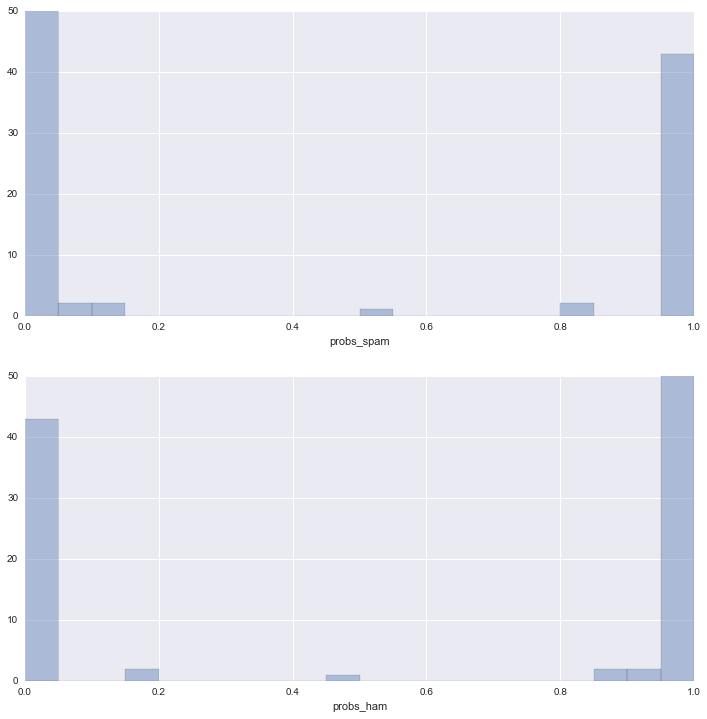

In [206]:
def hw_2_5_error():
    # Parse results
    columns = ['docid', 'label', 'preds', 'probs_spam', 'probs_ham']
    df = pd.read_table("hw_2_5_results.txt", header=None, names=columns)    
    # Calculate error rate and output
    print "The training error is {}.".format(np.mean(df['label'] != df['preds']))
    # Plot histograms
    plt.figure(figsize=(12,12))
    plt.subplot(211)
    sns.distplot(df['probs_spam'], bins = 20, kde=None)
    plt.subplot(212)
    sns.distplot(df['probs_ham'], bins = 20, kde=None)

hw_2_5_error()

Our training error went to 4% (up from 0% in HW2.4). By limiting our vocabulary to words with frequencies >= 3 (in each class), we effectively performed feature selection and lowered our model complexity due to the fewer number of parameters. As we see on the learning curve below (taken from Elements of Statistical Learning), the in-sample-error always drops as model complexity increases. In HW2.5, we traversed backwards on the learning curve from HW2.4. We expect our error to increase, matching our results. Nonetheless, we should keep in mind that we still have over 1500 features, which are still way too many for 100 examples. Our generalization likely won't be great because of the amount of overfitting.  
![learning](learning_curve.png)

### HW2.6 Benchmark your code with the Python SciKit-Learn implementation of the multinomial Naive Bayes algorithm

It always a good idea to benchmark your solutions against publicly available libraries such as SciKit-Learn, The Machine Learning toolkit available in Python. In this exercise, we benchmark ourselves against the SciKit-Learn implementation of multinomial Naive Bayes.  For more information on this implementation see: http://scikit-learn.org/stable/modules/naive_bayes.html more  

In this exercise, please complete the following:

- Run the Multinomial Naive Bayes algorithm (using default settings) from SciKit-Learn over the same training data used in HW2.5 and report the misclassification error (please note some data preparation might be needed to get the Multinomial Naive Bayes algorithm from SkiKit-Learn to run over this dataset)
- Prepare a table to present your results, where rows correspond to approach used (SkiKit-Learn versus your Hadoop implementation) and the column presents the training misclassification error
- Explain/justify any differences in terms of training error rates over the dataset in HW2.5 between your Multinomial Naive Bayes implementation (in Map Reduce) versus the Multinomial Naive Bayes implementation in SciKit-Learn 

In [2]:
# Import sklearn packages
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

In [425]:
def sklearn_NB(NB_model, vectorizer):
    '''
    Runs sklearn NB implentation on enron emails, using input choice of NB model and vectorizer
    '''
    # Load text file
    doc_ids, labels, content = [], [], []
    with open("enronemail_1h.txt", "r") as f:
        for line in f:
            # Some lines have missing subjects
            if len(line.split("\t")) == 4:
                doc_id, label, subject, body = line.split("\t")
            else:
                subject = "na"
                doc_id, label, body = line.split("\t")
            # Put into array format
            doc_ids.append(doc_id)
            labels.append(int(label))
            content.append(subject + " " + body)
    # Vectorize train_data
    content_vector = vectorizer.fit_transform(content)
    print "Vocab size: {}.".format(content_vector.shape[1])
    # Classify with sklearn NB model
    NB_model.fit(content_vector, labels)
    preds = NB_model.predict(content_vector)
    print "The classification error is: {}.".format(np.mean(np.array(labels) != preds))

# MultinomialNB, using terms of frequencies >= 3
sklearn_NB(MultinomialNB(), CountVectorizer(min_df=3))

Vocab size: 1357.
The classification error is: 0.04.


#### 2.6 Response

| Model                                                                      | Training Error   |
|----------------------------------------------------------------------------|------------------|
| Multinomial NB, MapReduce implementation (HW2.5)                           | 0.04             |
| Multinomial NB, Scikit-Learn Implementation (HW2.6)                        | 0.04             |

The MapReduce implementation performed the same as the sklearn implementation. The two models use different features. In the MapReduce implementation, we dropped terms with less than 3 occurrences, but kept all punctuations and numbers (besides the period and comma in position as delimiters). The sklearn implementation performed a more restrictive tokenization by removing all punctuation and any length-1 alphanumeric characters. The vocab size is 1357, compared to around 1800 for our MR model.  
  
From the above learning curve, we would expect the training error for the sklearn implementation to be a little higher. However, it is likely that the extra features that were removed are not predictive of the class and didn't affect training performance.

### HW 2.6.1 OPTIONAL (note this exercise is a stretch HW and optional)
- Run the Bernoulli Naive Bayes algorithm from SciKit-Learn (using default settings) over the same training data used in HW2.6 and report the misclassification error 
- Discuss the performance differences in terms of misclassification error rates over the dataset in HW2.5 between the  Multinomial Naive Bayes implementation in SciKit-Learn with the  Bernoulli Naive Bayes implementation in SciKit-Learn. Why such big differences. Explain. 

Which approach to Naive Bayes would you recommend for SPAM detection? Justify your selection.

In [426]:
# Run 2.6 with Bernoulli NB
# BernoulliNB, using terms of frequencies >= 3 and binary features
sklearn_NB(BernoulliNB(), CountVectorizer(min_df=3, binary=True))

Vocab size: 1357.
The classification error is: 0.12.


#### 2.6.1 Response

| Model                                                                      | Training Error   |
|----------------------------------------------------------------------------|------------------|
| Multinomial NB, MapReduce implementation (HW2.5)                           | 0.04             |
| Multinomial NB, Scikit-Learn Implementation (HW2.6)                        | 0.04             |
| Bernoulli NB, Scikit-Learn Implementation (HW2.6.1)                        | 0.12             |

The Bernoulli NB model performed the worst, with a 12% error versus 4% for the multinomial models. Multinomial NB represents features as term occurrences, models probability with a multinomial distribution of terms, and only considers terms in the document. Bernoulli NB represents features as a binary vector (of whether a particular term appears in a document), models probability with a Bernoulli distribution, and considers both appearance and non-apperaance of terms in the document. Because Bernoulli NB does not use information about repeated occurrence of a word in a doc, it leaves a lot of information on the table during classification. Multinomial NB uses more information and represents the document in a more nuanced way.  

For spam classification in emails, Multinomial NB works better, because multiple occurrences are likely to be important in predicting the class. There is a big difference between "assistance" appearing once and "assistance" appearing 5 times. Multinomial NB will take the 5 occurrences into account and assigns heavy probability to the spam class. On the other hand, Bernoulli NB only note the appearnce of "assistance".

### HW2.7 OPTIONAL (note this exercise is a stretch HW and optional)

The Enron SPAM data in the following folder enron1-Training-Data-RAW is in raw text form (with subfolders for SPAM and HAM that contain raw email messages in the following form:

--- Line 1 contains the subject
--- The remaining lines contain the body of the email message.

In Python write a script to produce a TSV file called train-Enron-1.txt that has a similar format as the enronemail_1h.txt that you have been using so far. Please pay attend to funky characters and tabs. Check your resulting formated email data in Excel and in Python (e.g., count up the number of fields in each row; the number of SPAM mails and the number of HAM emails). Does each row correspond to an email record with four values? Note: use "NA" to denote empty field values.

In [354]:
%%writefile enron_merge.py
#!/usr/bin/env python
from __future__ import unicode_literals
import os
import string
import codecs

# Home directory
home_path = os.getcwd()
os.chdir(os.path.join(home_path, "enron1-training-data-raw"))
# Label mapping
label_map = {"spam":"1", "ham":"0"}
# Output
out_path = os.path.join(home_path, "train-Enron-1.txt")

# Iterate over directory
with open(out_path, "w") as out_file:
    for root, dirs, filenames in os.walk(os.getcwd()):
        # Skip irrelevant folders
        if not(root.endswith("spam") or root.endswith("ham")):
            continue
        # Spam and ham folders
        for filename in filenames:            
            # Skip Mac internal files
            if filename.startswith("."):
                continue
            # Process each file
            doc_id, label, ext = os.path.basename(filename).rsplit(".", 2)
            label = label_map[label]
            # Ignore characters with non-standard coding
            with codecs.open(os.path.join(root, filename), "r", encoding='utf-8', errors='replace') as email:                
                # Only take printable characters
                subject = email.readline()
                subject = filter(lambda x: x in string.printable, subject)
                subject = subject.strip().split("Subject: ")
                if len(subject)!=2 or not subject[1]:
                    subject = "NA"
                else:                    
                    subject = subject[1]
                # Strip newlines to convert to string    
                body = email.read()
                body = filter(lambda x: x in string.printable, body)
                body = body.strip().replace('\r\n', '')
                if not body:
                    body = "NA"
            # Write to output file
            out_file.write(('\t'.join([doc_id, label, subject, body]) + '\n').encode('ascii', 'replace'))

Overwriting enron_merge.py


In [355]:
!./enron_merge.py

In [222]:
!chmod a+x enron_merge.py

In [356]:
!wc -l train-Enron-1.txt

    5172 train-Enron-1.txt


In [357]:
!head train-Enron-1.txt

0001.1999-12-10.farmer	0	christmas tree farm pictures	NA
0002.1999-12-13.farmer	0	vastar resources , inc .	gary , production from the high island larger block a - 1 # 2 commenced onsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .george x 3 - 6992- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16am - - - - - - - - - - - - - - - - - - - - - - - - - - -daren j farmer12 / 10 / 99 10 : 38 amto : carlos j rodriguez / hou / ect @ ectcc : george weissman / hou / ect @ ect , melissa graves / hou / ect @ ectsubject : vastar resources , inc .carlos ,please call linda and get everything set up .i ' m going to estimate 4 , 500 coming up tomorrow , with a 2 , 000 increase eachfollowing day based on my conversations with bill fischer at bmar .d .- - - - - - - - - - - - - - - - - - - - - - forwarded by daren j farmer / hou / ect on 12 /

### HW2.8 OPTIONAL
Using Hadoop Map-Reduce write job(s) to perform the following:
- Train a multinomial Naive Bayes Classifier with Laplace plus one smoothing using the data extracted in HW2.7 (i.e., train-Enron-1.txt). Use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). Drop tokens with a frequency of less than three (3).
- Test the learnt classifier using enronemail_1h.txt and report the misclassification error rate. Remember to use all white-space delimitted tokens as independent input variables (assume spaces, fullstops, commas as delimiters). How do we treat tokens in the test set that do not appear in the training set?

In [377]:
!hdfs dfs -put train-Enron-1.txt /user/konniam/week_02

16/01/25 20:40:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2.8 Strategy
Using the entire corpus producted in 2.7, we use a similar 2-step training/classifcation strategy to learn a NB model.

#### 2.8 Training

In [367]:
%%writefile ~/mapper.py
#!/usr/bin/env python
## mapper.py
## Author: Konniam Chan
## Description: mapper code for HW2.8
from __future__ import unicode_literals
import sys
import re
from collections import Counter

# Map from integer label to word label
label_map = {"1":"spam", "0":"ham"}
# Dictionary to keep track of terms
wordcounts = {"spam": Counter(), "ham": Counter()}
# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')

# Process each document
for line in sys.stdin:
    # Lower case
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "NA"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    # Sum words that go through each mapper
    label = label_map[label]
    wordcounts[label] += Counter(words)
    # Increment number of documents
    wordcounts[label]["*numdocs"] += 1
# Delete any stray spaces
del wordcounts['spam']['']
del wordcounts['ham']['']
# Output each word
for label in wordcounts:
    for word in wordcounts[label]:
        print '%s\t%s\t%s'.encode('ascii', 'replace') % (word, label, wordcounts[label][word])

Overwriting /Users/InfernoIX/mapper.py


In [372]:
%%writefile ~/reducer.py
#!/usr/bin/env python
## reducer.py
## Author: Konniam Chan
## Description: reducer code for HW2.8
import sys
from collections import Counter

# Dictionary to keep track of terms
wordcounts = {"spam": Counter(), "ham": Counter()}
# Process each tuple in the form of (word, spam/ham, count) separated by \t
for line in sys.stdin:
    word, label, count = line.strip().split("\t")
    wordcounts[label][word] += int(count)

# Output each word
for label in wordcounts:
    for word in wordcounts[label]:
        print '%s\t%s\t%s' % (word, label, wordcounts[label][word])

Overwriting /Users/InfernoIX/reducer.py


In [378]:
# Run MapReduce job
# Specify 1 reducer
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=1 \
-mapper ~/mapper.py \
-reducer ~/reducer.py \
-input /user/konniam/week_02/train-Enron-1.txt \
-output /user/konniam/week_02/hw_2_8_output

16/01/25 20:40:57 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar8638680243381962498/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob4305228516953118512.jar tmpDir=null
16/01/25 20:40:59 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/25 20:40:59 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/25 20:41:00 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/25 20:41:00 INFO mapreduce.JobSubmitter: number of splits:2
16/01/25 20:41:01 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453765434085_0006
16/01/25 20:41:01 INFO impl.YarnClientImpl: Submitted application application_1453765434085_0006
16/01/25 20:41:01 INFO mapreduce.Job: The url to track the job: http://Konniams-MacBook-Air.local:8088/proxy/application_1453765434085_0006/
16/

In [379]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_8_output/part* | sort -k1,1 | head

16/01/25 20:43:46 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
!	ham	683
!	spam	1288
!"	spam	1
!$	ham	1
!$	spam	2
!$68	spam	1
!%	spam	11
!'	spam	1
!(	ham	7
!(	spam	1
sort: write failed: standard output: Broken pipe
sort: write error


The above MR job trained the model by obtaining the counts of all terms in either spam or ham.  
We can now pass the result file from above when we want to classify our training data.

In [380]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_8_output/part* | wc -l

16/01/25 21:48:04 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
   84938


In [383]:
# Save wordcounts to file on local drive
!hdfs dfs -cat /user/konniam/week_02/hw_2_8_output/part* > ~/wordcounts_2_8.txt

16/01/25 22:06:08 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Run 2nd-stage MR job to classify the small email set, using the entire corpus:

#### 2.8 Classification

In [381]:
%%writefile ~/mapper_classify.py
#!/usr/bin/env python
## mapper_classify.py
## Author: Konniam Chan
## Description: classification (with Laplace smoothing, ignore infrequent terms) 
## mapper code for HW2.8
from __future__ import division
import sys
import re
import math
from collections import defaultdict

# Map from integer label to word label
label_map = {"1":"spam", "0":"ham"}
# Regex split objects with specified delimiters (space, period, comma)
regex_beg = re.compile(r'^[\s.,"]+')
regex_end = re.compile(r'[\s.,"]+$')
regex_split = re.compile(r'[\s.,]+')

# Load wordcounts from 2.8 in memory
wordcounts = {"spam": defaultdict(int), "ham": defaultdict(int)}
with open("wordcounts_2_8.txt", "r") as f:
    for line in f:
        word, label, count = line.strip().split("\t")
        wordcounts[label][word] = int(count)
# Drop terms with total frequencies less than 3
vocab_set = set(wordcounts['spam']).union(set(wordcounts['ham']))
for word in vocab_set:
    if (wordcounts['spam'][word] + wordcounts['ham'][word]) < 3:
        del wordcounts['spam'][word]
        del wordcounts['ham'][word]
# Update vocabulary after deletion    
vocab_set = set(wordcounts['spam']).union(set(wordcounts['ham']))        
vocab_size = len(vocab_set)

# Calculate total number of terms
terms_spam = sum(wordcounts['spam'].values())
terms_ham = sum(wordcounts['ham'].values())
# Calculate priors and size of vocab
prior_spam = wordcounts['spam']['*numdocs'] / (wordcounts['spam']['*numdocs'] + wordcounts['ham']['*numdocs'])
prior_ham = 1 - prior_spam


# Process each document
for line in sys.stdin:
    line = line.strip().lower()
    # Some lines have missing subjects
    if len(line.split("\t")) == 4:
        doc_id, label, subject, body = line.split("\t")
    else:
        subject = "na"
        doc_id, label, body = line.split("\t")
    # Remove delimiters at beginning and end of subjects and body
    subject = regex_beg.sub('', subject)
    subject = regex_end.sub('', subject)
    body = regex_beg.sub('', body)
    body = regex_end.sub('', body)
    # Split into words
    words = regex_split.split(subject + " " + body)
    
    # Initialize probabilities with priors
    log_probs = {"spam": math.log(prior_spam), "ham": math.log(prior_ham)}
    # Iterate through each word and add probabilities
    for word in words:
        # Skip words that aren't in the vocab
        if word not in wordcounts['spam'] and word not in wordcounts['ham']:
            continue            
        # Laplace smoothing
        log_probs["spam"] += math.log((wordcounts['spam'][word] + 1) / 
                                      (terms_spam + vocab_size))
        log_probs["ham"] += math.log((wordcounts['ham'][word] + 1) / 
                                     (terms_ham + vocab_size))

    # Classify
    predicted_label = "1" if log_probs["spam"] > log_probs["ham"] else "0"
    # Normalize probabilities for output, prevent overflow
    if log_probs["ham"] - log_probs["spam"] > 700:
            probs_spam = 0
    else:
        probs_spam = 1 / (1 + math.exp(log_probs["ham"] - log_probs["spam"]))
    probs_ham = 1 - probs_spam
    
    # Output (DocID, label, predicted label, p_spam, p_ham)
    print '\t'.join([doc_id, label, predicted_label, 
                     str(probs_spam), str(probs_ham)])

Overwriting /Users/InfernoIX/mapper_classify.py


In [387]:
# Run MapReduce job
# Map-only job. Pass in text file with wordcounts
!hadoop jar hadoop-streaming-2.7.1.jar \
-D mapreduce.job.reduces=0 \
-mapper ~/mapper_classify.py \
-input /user/konniam/week_02/enronemail_1h.txt \
-output /user/konniam/week_02/hw_2_8_output_classify \
-file ~/wordcounts_2_8.txt

16/01/25 22:09:35 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
16/01/25 22:09:35 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
packageJobJar: [/Users/InfernoIX/wordcounts_2_8.txt, /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/hadoop-unjar5326725080188935528/] [] /var/folders/l8/h51_59852qscq403fs6q0xlh0000gn/T/streamjob5623131734998070025.jar tmpDir=null
16/01/25 22:09:37 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/25 22:09:37 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
16/01/25 22:09:38 INFO mapred.FileInputFormat: Total input paths to process : 1
16/01/25 22:09:38 INFO mapreduce.JobSubmitter: number of splits:2
16/01/25 22:09:38 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1453765434085_0008
16/01/25 22:09:39 INFO impl.YarnClientImpl: Submitted application application_145376543408

In [427]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_8_output_classify/* | head

16/01/25 23:55:16 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
0011.2003-12-18.gp	1	1	1.0	0.0
0011.2004-08-01.bg	1	1	1.0	0.0
0012.1999-12-14.farmer	0	0	5.31855091372e-127	1.0
0012.1999-12-14.kaminski	0	0	1.31343541076e-29	1.0
0012.2000-01-17.beck	0	0	1.53420842707e-39	1.0
0012.2000-06-08.lokay	0	1	1.0	4.04121180964e-14
0012.2001-02-09.kitchen	0	0	6.46025337376e-10	0.999999999354
0012.2003-12-19.gp	1	1	0.999999983328	1.66724848372e-08
0013.1999-12-14.farmer	0	0	1.84396706319e-35	1.0
0013.1999-12-14.kaminski	0	0	4.83587857574e-19	1.0
cat: Unable to write to output stream.


### HW2.8.1 OPTIONAL
- Run  both the Multinomial Naive Bayes and the Bernoulli Naive Bayes algorithms from SciKit-Learn (using default settings) over the same training data used in HW2.8 and report the misclassification error on both the training set and the testing set
- Prepare a table to present your results, where rows correspond to approach used (SciKit-Learn Multinomial NB; SciKit-Learn Bernouili NB; Your Hadoop implementation)  and the columns presents the training misclassification error, and the misclassification error on the test data set
- Discuss the performance differences in terms of misclassification error rates over the test and training datasets by the different implementations. Which approch (Bernouili versus Multinomial) would you recommend for SPAM detection? Justify your selection.

#### 2.8.1 Error Assessment

In [390]:
!hdfs dfs -cat /user/konniam/week_02/hw_2_8_output_classify/part* > hw_2_8_results.txt

16/01/25 22:15:06 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


The training error is 0.12.


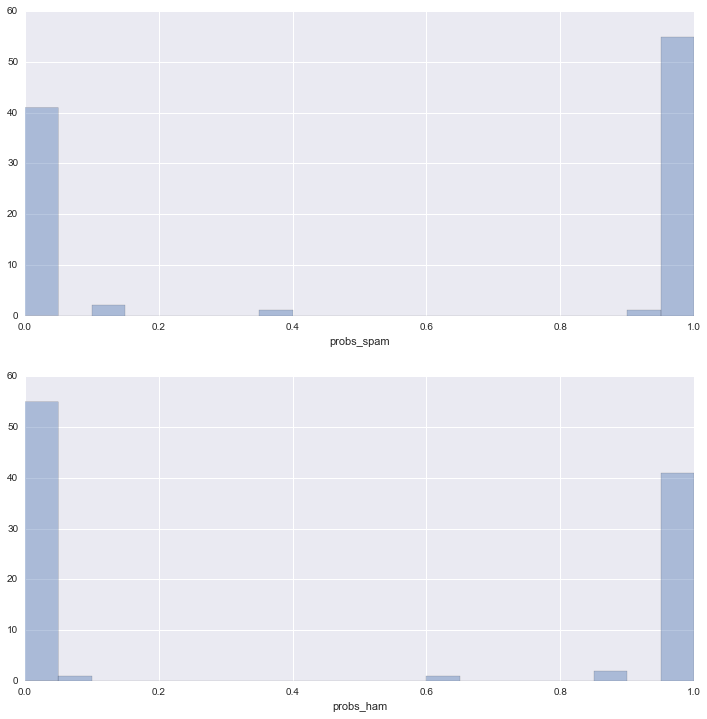

In [391]:
def hw_2_8_error():
    # Parse results
    columns = ['docid', 'label', 'preds', 'probs_spam', 'probs_ham']
    df = pd.read_table("hw_2_8_results.txt", header=None, names=columns)    
    # Calculate error rate and output
    print "The training error is {}.".format(np.mean(df['label'] != df['preds']))
    # Plot histograms
    plt.figure(figsize=(12,12))
    plt.subplot(211)
    sns.distplot(df['probs_spam'], bins = 20, kde=None)
    plt.subplot(212)
    sns.distplot(df['probs_ham'], bins = 20, kde=None)

hw_2_8_error()

In [403]:
def hw_2_8_1(NB_model, binary_features=False):
    '''
    Runs sklearn NB implentation on enron emails, using input choice of NB model
    '''
    # Load train and test data
    data = {"train": {"path":"train-Enron-1.txt", "doc_ids":[], "labels":[],
                      "content":[]},   
            "test": {"path": "enronemail_1h.txt", "doc_ids":[], "labels":[],
                     "content":[]}}
    vectorizer = CountVectorizer(min_df=3, binary=binary_features)
    
    # Vectorize train
    with open(data["train"]["path"], "r") as f:
        for line in f:            
            doc_id, label, subject, body = line.split("\t")
            data["train"]["doc_ids"].append(doc_id)
            data["train"]["labels"].append(int(label))
            data["train"]["content"].append(subject + " " + body)
    # Vectorize
    data["train"]["content_vector"] = vectorizer.fit_transform(data["train"]["content"])
        
    # Vectorize test data
    with open(data["test"]["path"], "r") as f:
        for line in f:
            # Some lines have missing subjects
            if len(line.split("\t")) == 4:
                doc_id, label, subject, body = line.split("\t")
            else:
                subject = "NA"
                doc_id, label, body = line.split("\t")
            # Put into array format
            data["test"]["doc_ids"].append(doc_id)
            data["test"]["labels"].append(int(label))
            data["test"]["content"].append(subject + " " + body)
    # Vectorize
    data["test"]["content_vector"] = vectorizer.transform(data["test"]["content"])

    # Classify with sklearn NB model
    NB_model.fit(data["train"]["content_vector"], data["train"]["labels"])
    preds = NB_model.predict(data["test"]["content_vector"])
    print "The classification error is: {}.".format(np.mean(np.array(data["test"]["labels"]) != preds))

# MultinomialNB, using terms of frequencies >= 3
hw_2_8_1(MultinomialNB(), False)

The classification error is: 0.07.


In [404]:
# Bernoulli NB
hw_2_8_1(BernoulliNB(), binary_features=True)

The classification error is: 0.08.


#### 2.8.1 Response

| Model                                                                      | Training Error   |
|----------------------------------------------------------------------------|------------------|
| Multinomial NB, MapReduce implementation                                   | 0.12             |
| Multinomial NB, Scikit-Learn Implementation                                | 0.07             |
| Bernoulli NB, Scikit-Learn Implementation                                  | 0.08             |

The sklearn implementatiaons performed better than the MR implementation. The main difference between the two is the feature selection process, as sklearn strips out all punctuations. It is likely that these stripped features are noisy and don't offer predictive power, making the sklearn models better overall.